In [1]:
import numpy as np
import pandas as pd
import os
from time import time
import warnings

### Debug only
__file__ = r"./Reorganize.ipynb"

# Data Import Group

## Import Entso-E

### Import data

In [2]:
def import_data(ctry, start=None, end=None, freq="H", target="CH",
                involved_countries=None, prod_gap=None, sg_data=None,
                path_gen=None, path_gen_raw=None, path_imp=None, path_imp_raw=None,
                savedir=None, savegen=None, saveimp=None,
                residual_global=False, correct_imp=True, n_hours=2, days_around=7, is_verbose=True):
    
    """
    Main function managing the import and pre-treatment of Entso-e production and cross-border flow data.
    
    Patameter:
        ctry: list of countries to include in the computing (list)
        start: starting date (str or datetime)
        end: ending date (str or datetime)
        freq: time step (str, default: H)
        target: target country (str, default: CH)
        involved_countries: list of all countries involved, with the countries to include in the computing
                            and their neighbours (to implement the exchanges with 'Other' countries)
                            (list, default: None)
        prod_gap: information about the nature of the residual (pandas DataFrame)
        sg_data: information from Swiss Grid (pandas DataFrame, default: None)
        path_gen: directory where preprocessed Entso-e generation files are stored (str)
        path_imp: directory containing the files for preprocessed cross-border flow data (str)
        path_gen_raw: directory where raw Entso-e generation files are stored (str)
        path_imp_raw: directory containing the raw Entso-E files for cross-border flow data (str)
        savedir: directory to save auxilary information for loaded data (str, default: None)
        savegen: directory to save generation data from raw files (str, default: None)
        saveimp: directory to save exchanges data from raw files (str, default: None)
        residual_global: to consider the production residual as produced electricity that can be
                        exchanged with neighbour countries (bool, default: False)
        correct_imp: to replace cross-border flow of Entso-e for Swizerland with data from Swiss Grid
                    (bool, default: False)
        n_hours: Max number of successive missing hours to be considered as occasional event
                (int, default: 2)
        days_around: number of days after and before a gap to consider to create a 'typical mean day'
                (int, default: 7)
        is_verbose: to display information (bool, default: False)
    
    Return:
        pandas DataFrame with all productions and all exchanges from all included countries.
    """
    
    t0 = time()
    
    ### GENERATION DATA
    Gen = import_generation(path_gen=path_gen, path_raw=path_gen_raw, ctry=ctry,
                            start=start, end=end, savedir=savedir, savegen=savegen,
                            is_verbose=is_verbose) # import generation data
    Gen = adjust_generation(Gen, freq=freq, residual_global=residual_global, sg_data=sg_data,
                            n_hours=n_hours, days_around=days_around, prod_gap=prod_gap,
                            is_verbose=is_verbose) # adjust the generation data
    
    ### EXCHANGE DATA
    Cross = import_exchanges(neighbourhood=involved_countries, ctry=ctry,
                             start=start, end=end, savedir=savedir, saveimp=saveimp,
                             path_imp=path_imp, path_raw=path_imp_raw, freq=freq, is_verbose=is_verbose) # Imprt data
    
    # Correct the cross-border flows at Swiss border.
    if correct_imp:
        if is_verbose: print("Adapt Exchage Data of Swizerland...")
        Cross = adjust_exchanges(Cross=Cross,sg_data=sg_data,freq=freq) # Adjust the exchange data
    
    ### GATHER GENERATION AND EXCHANGE
    electric_mix = _join_generation_exchanges(Gen=Gen, Cross=Cross, is_verbose=is_verbose)
    
    
    if is_verbose: print("Import of data: {:.1f} sec".format(time()-t0))
    return electric_mix

### Import Generation

In [3]:
def import_generation(ctry, start, end, path_gen=None, path_raw=None,
                      savedir=None, savegen=None, saveimp=None, is_verbose=False):
    """
    Function to import generation data from Entso-e information source.
    
    Parameter:
        path_gen: directory where preprocessed Entso-e generation files are stored (str) [prioritary path]
        path_gen_raw: directory where raw Entso-e generation files are stored (str) [secondary path]
        ctry: countries to incldue in the study (list)
        start: starting date (str or datetime)
        end: ending date (str or datetime)
        savedir: directory path to save auxilary results (str, default: None)
        savegen: directory path to save generation files (str, if path_raw not None, default: None)
        is_verbose: to display information (bool, default: False)
    """
    path = None
    if path_gen is None: path = path_raw
    else: path = path_gen # default path is the preprocessed files
    if path is None:
        raise KeyError("No path is given for Generation data.")
    
    #######################
    ###### Generation data
    #######################

    if is_verbose: print("Load generation data...")
    # Selecton of right files according to the choice of countres
    if path_gen is not None:
        files = {}
        for c in ctry: # Gather prepared files per country
            try:
                files[c] = [f for f in os.listdir(path) if f.find(c)!=-1][0]
            except Exception as e:
                raise KeyError(f"No generation data for {c}: {e}")
                
        Gen = {} # Dict for the generation of each country
        
    elif path_raw is not None: # Just fill the Gen directly for row files
        Gen = extract(ctry=ctry, dir_gen=path, savedir_gen=savegen,
                      save_resolution=savedir, is_verbose=is_verbose) # if from raw files

    for c in ctry:# Preprocess all files / data per country
        # Extract the generation data file
        if path_gen is not None: # Load preprocessed files
            Gen[c] = pd.read_csv(path+files[c],index_col=0) # Extraction of preprocessed files
        
        # Check and modify labels if needed
        add_space = pd.Index(np.array([k[-1] for k in Gen[c].columns])!=[' ']) # all cols not ending with ' '
        Gen[c].columns = Gen[c].columns + add_space*" "
            
        # Set indexes to time data
        Gen[c].index = pd.to_datetime(Gen[c].index,yearfirst=True) # Convert index into datetime
        
        # Only select the required piece of information
        Gen[c] = Gen[c].loc[start:end]

        source = list(Gen[c].columns) # production plants types
        if np.any(source=="Other "): # rename one specific column
            source[source.index("Other ")] = "Other fossil "

        Gen[c].columns = [s.replace(" ","_")+c for s in source] # rename columns
        
    return Gen

### Adjust Generation

In [4]:
def adjust_generation(Gen, freq='H', residual_global=False, sg_data=None, n_hours=2, days_around=7,
                      prod_gap=None, is_verbose=False):
    """Function that leads organizes the data adjustment.
    It sorts finds and sorts missing values, fills it, resample the data and
    add a residual as global production
    
    Parameter:
        Gen: dict of dataFrames containing the generation for each country
        freq: time step durtion (str, default: H)
        residual_prod: whether to include the residual or not (bool, default: False)
        sg_data: information from Swiss Grid (pandas DataFrame, default: None)
        n_hours: Max number of successive missing hours to be considered as occasional event
                (int, default: 2)
        days_around: number of days after and before a gap to consider to create a 'typical mean day'
                (int, default: 7)
        prod_gap: information about the nature of the residual (pandas DataFrame)
        is_verbose: bool. Whether to display information or not.
        
    Return
        dict of pandas DataFrames: modified Gen dict.
    """
    ### Identify missing values
    Empty_Gen, Empty_Nuc = gather_missing_generation(Gen=Gen,
                                                      add_on=residual_global,
                                                      is_verbose=is_verbose)
    ### Classify missing values as occasional or missing period
    Empty_Unique, Empty_Period = sort_missing_generation(Empty_Gen=Empty_Gen,
                                                          Empty_Nuc=Empty_Nuc,
                                                          n_hours=n_hours,
                                                          add_on=residual_global,
                                                          is_verbose=is_verbose)
    ### Fill missing values consequently
    Gen = fill_missing_generation(Gen,
                                   Empty_Unique=Empty_Unique,
                                   Empty_Period=Empty_Period,
                                   n_hours=n_hours,
                                   days_around=days_around,
                                   add_on=residual_global,
                                   is_verbose=is_verbose)
    
    ### Resample data to the right frequence
    Gen = resample_generation(Gen=Gen, freq=freq, add_on=residual_global, is_verbose=is_verbose)
    
    ### Includes residual production
    if residual_global:
        Gen = include_global_residual(Gen=Gen, freq=freq, sg_data=sg_data, prod_gap=prod_gap,
                                       is_verbose=is_verbose)
    
    return Gen

### Gather missing generation

In [5]:
def gather_missing_generation(Gen, add_on=False, is_verbose=False):
    """
    Function to find missing information in the Entso-e data.
    It distinguishes missing values and missing nuclear generation.
    Parameter:
        Gen: dict of pandas DataFrame with production data for each country.
        add_on: display flourish (bool, default: False)
        is_verbose: to display information (bool, default: False)
    Return:
        2 dict of lists, one with dates of missing generations and one with dates of missing nuclear
    """
    #######################
    ### Correction of Generation data
    #######################
    if is_verbose: print(f"Correction of generation data:\n\t1/{4+int(add_on)} - Gather missing values...")
    ### Data with no nuclear production (good repair for missng datas)
    ## Exceptions to nuclear missing datas
    NoNuc = ["CH"] # There is no problem with swiss -> missing values are OK !
    for f in Gen.keys(): # for all countries
        if Gen[f]["Nuclear_{}".format(f)].sum()==0: # if the sum of all nuclear production is null
            NoNuc.append(f) # register the country as non nuclear producer
    
    
    ### Dates with partial or total missing production
    Empty_Gen = {} # total missing production
    Empty_Nuc = {} # partial missing production
    empty_nuc = [] # to store some missing data
    for f in Gen.keys(): # for all considered countries
        # Missing production
        Empty_Gen[f] = list(Gen[f][Gen[f].sum(axis=1)==0].index) # list of dates of missing production
        
        # Missing nuclear
        if f in NoNuc: # if country without nuclear
            Empty_Nuc[f]=[] # nothing to look for
        else:
            Empty_Nuc[f] = []
            empty_nuc = list(Gen[f][Gen[f]["Nuclear_{}".format(f)]==0].index) # dates of missing nuclear
            for k in empty_nuc:
                if k not in Empty_Gen[f]: # if not already in missing generation data...
                    Empty_Nuc[f].append(k) # ... then append it into list of "only" missing nuclear
    
    return Empty_Gen, Empty_Nuc

### Sort missing generation

In [6]:
def sort_missing_generation(Empty_Gen, Empty_Nuc, n_hours=2, add_on=False, is_verbose=False):
    """
    Function that classifies the missing values to prepare for value filling.
    Parameter:
        Empty_Gen: dict of missing data for all units at one time step.
        Empty_Nuc: dict of missing values in nuclear production (for countries with nuclear production)
        n_hour: Max number of successive missing hours to be considered as occasional event
                (int, default: 2)
        add_on: display flourish (bool, default: False)
        is_verbose: to display information (bool, default: False)
    Return:
        2 dict of lists of missing moments and one for missing periods.
    """
    if is_verbose: print(f"\t2/{4+int(add_on)} - Sort missing values...")
    ### Distinction between periods of missing data and occasional ones.
    Empty_Period = {}
    Empty_Unique = {}
    
    for f in Empty_Gen.keys():
        Empty_Period[f] = []
        Empty_Unique[f] = []
        Empty = sorted(Empty_Gen[f] + Empty_Nuc[f]) # sort all missing datas together (nuclear and not nuclear)
        if len(Empty)==0:
            pass # if nothing is missing -> nothing is done
        elif len(Empty)<=n_hours: # if only few missing dates...
            for t in Empty_Gen[f]:
                Empty_Unique[f].append(t) # ...everything registered as occasional missing datas.
        else:
            t,h = 1,0
            while t<len(Empty): # look through all datas
                if Empty[t]==Empty[h]+pd.Timedelta("{} hour".format(t-h)): # if 2 datas from the same "period"
                    t+=1 # go for looking if the next date belongs to the period too
                else: # if different "periods"...
                    if t-h>n_hours: # if the period is longer than the limit
                        Empty_Period[f].append((Empty[h],t-h)) # Register (start,duration) as a period 
                    else: # if period is 1 or 2 hours long
                        for i in range(t-h):
                            Empty_Unique[f].append(Empty[h+i]) # add all investigated datas of this period as occasional missing data
                    h += t-h # beginning of another "period" investigationo
                    t+=1 # hour 0 of the group already seen --> go to possible hour 2.
            
            if t-h>n_hours: # for the last "period", if it is long enough
                Empty_Period[f].append((Empty[h],t-h)) # Stock (start,duration) as a period
            else: # if period is 1 or 2 hours long
                for i in range(t-h):
                    Empty_Unique[f].append(Empty[h+i]) # add all investigated datas of this period as occasional missing data
    
    return Empty_Unique, Empty_Period

### Fill missing generation

In [7]:
def fill_missing_generation(table, Empty_Unique, Empty_Period, n_hours=2, days_around=7,add_on=False,
                            is_verbose=False):
    """
    Function to fill the missing values in generation data.
    Parameter:
        table: pandas DataFrame with the generation data.
        Empty_Unique: dict of missing values considered as occasional
        Empty_Period: dict of missing values considered as a whole period
        n_period: Max number of successive missing hours to be considered as occasional event
                (int, default: 2)
        days_around: number of days after and before a gap to consider to create a 'typical mean day'
                (int, default: 7)
        add_on: display flourish (bool, default: False)
        is_verbose: to display information (bool, default: False)
    """
    if is_verbose: print(f"\t3/{4+int(add_on)} - Fill missing values...")
        
    ### Filling all missing values
    for f in table.keys(): # for all countries
        
        ### First: fill occasional data
        table[f] = fill_occasional(table=table[f], empty=Empty_Unique[f], n_hours=n_hours)
        
        ### Second: fill periods
        table[f] = fill_periods(table=table[f], empty=Empty_Period[f], days_around=days_around)
    return table

### Fill occasional

In [8]:
def fill_occasional(table, empty, n_hours=2):
    """
    Function to fill occasional missing data. Only used for missing of 2 missing hours in a row or less.
    Parameter:
        table: pandas DataFrame with the generation data
        empty: the list of empty slots considered as occasional
        n_hours: Max number of successive missing hours to be considered as occasional event
                    (int, default: 2)
    """
    filled_table = table.copy()
    miss = empty.copy() # copy of list of missing dates
    
    for t in empty: # for all missing dates
        col = table.loc[t][table.loc[t]==0].index # list of power station to fill (not always all)
        
        try:
            if t+pd.Timedelta("1 hour") in miss: # If 2 hours in a row
                # Replace first missing value with: 1/3 of difference between value(2h after) and value(1h before)
                filled_table.loc[t,col] = round((1/3)*filled_table.loc[t+pd.Timedelta("2 hour"),col]\
                        + (2/3)*filled_table.loc[t-pd.Timedelta("1 hour"),col]  , 2) # rounded at 0.01

            else: # if single missing hour (or second of a pair) -> linear extrapolation
                filled_table.loc[t,col] = (1/2)*(filled_table.loc[t+pd.Timedelta("1 hour"),col] \
                        + filled_table.loc[t-pd.Timedelta("1 hour"),col])
        except KeyError as e:
            raise ValueError(f"Missing data identified in the first or last time step. Impossible to fix: {e}")

        miss.remove(t) # treated hour removed from copied list (to avoid errors)
    return filled_table

### Fill periods

In [9]:
def fill_periods(table, empty, days_around=7):
    """
    Function to fill the missing periods with typical day values
    Parameter:
        table: pandas DataFrame with the generation data
        empty: the list of empty slots considered as periods
        days_around: number of days after and before a gap to consider to create a 'typical mean day'
                     (int, default: 7)
    """
    filled_table = table.copy()
    miss = empty.copy() # copy of the missing periods of the country (not to alter it)
    
    for t in miss: # for all missing periods
        # List of columns to fill (if column is null for the whole duration)
        delta = pd.Timedelta("{} minutes".format(15*(t[1]-1))) # entierty of the gap, in minutes
        col = filled_table.columns[(filled_table.loc[t[0]:t[0]+delta].sum()==0).values]

        # Missing data marked as "NaN". Data then not taken into account in the "typical mean day"
        filled_table.loc[t[0]:t[0]+delta,col]=np.nan

        # Creates the "typical mean day" (Average of the considered period)
        early = t[0]-pd.Timedelta("{} days".format(days_around))
        late = t[0]+pd.Timedelta("{} days + {} minutes".format(days_around, 15*(t[1]-1)))
        period = filled_table.loc[early:late,col].copy() # surrounding table

        typ_day = period.groupby(by=lambda x:(x.hour,x.minute)).mean() # "typical mean day"
        typ_day.index = pd.date_range(start="2018", periods=typ_day.shape[0], freq="15min")
        
        for dt in typ_day.index:
            loc_large = ((filled_table.index.minute==dt.minute)&(filled_table.index.hour==dt.hour))
            localize = filled_table[loc_large].loc[t[0]:t[0]+delta].index
            filled_table.loc[localize,col] = typ_day.loc[dt, col]
            
            
    return filled_table

### Resample generation

In [10]:
def resample_generation(Gen, freq, add_on=False, is_verbose=False):
    """
    Function that resamples the generation data. It can only downsample (lower the resolution) by summing.
    
    Parameter:
        Gen: dict of DataFrames containing the generation data.
        freq: the time step (resolution)
        add_on: a display flourish (bool, default: False)
        is_verbose: to display information (bool, default: False)
    
    Return:
        dict of pandas DataFrame wiht resampled productions
    """
    #######################
    ###### Resample Gen.
    #######################
    if ((check_frequency(freq))&(freq!='15min')):
        if is_verbose: print(f"\t4/{4+int(add_on)} - Resample Generation data to {freq} steps...")
        for f in Gen.keys(): # For all countries
            Gen[f] = Gen[f].resample(freq).sum() # Sum as we talk about energy.
            
    return Gen

### Import Exchanges

In [11]:
def import_exchanges(neighbourhood, ctry, start, end, path_imp=None, path_raw=None,
                     savedir=None, saveimp=None, freq='H', is_verbose=False):
    """
    Function to import the cross-border flows.
    Finds the useful files to load, load the data, group relevant information and adjust time step.
    
    Parameter:
        path_imp: directory containing the files for cross-border flow data (str)
        neighbours: list of useful countries, including neighbour of involved countries (list)
        ctry: list of countries to be represented in the simulation
        start: starting date (str or datetime)
        end: ending date (str or datetime)
        freq: time step (str, default: H)
        is_verbose: display information (bool, default: False)
    """
    path = None
    if path_imp is None: path = path_raw
    else: path = path_imp # default path is the preprocessed files
    if path is None:
        raise KeyError("No path is given for Exchange data.")
    
    if is_verbose: print("Get and reduce importation data...")
        
    ### Files to consider
    if path_imp is not None:
        files = {}
        for c in ctry:
            try:
                files[c] = [f for f in os.listdir(path_imp) if f.find(c)!=-1][0]
            except Exception as e:
                raise KeyError(f"No exchange data for {c}: {e}")
                
        Cross = {} # Dict for the generation of each country
        
    elif path_raw is not None: # Just fill the Gen directly for row files
        Cross = extract(ctry=ctry, dir_imp=path, savedir_imp=saveimp,
                        save_resolution=savedir, is_verbose=is_verbose) # if from raw files

    
    for i,c in enumerate(ctry):# File extraction
        if path_imp is not None:
            if is_verbose: print("\t{}/{} - {}...".format(i+1,len(files),c))
            Cross[c] = pd.read_csv(path_imp+files[c],index_col=0) # Extraction

        # Transform index in time data and convert it from UTC to CET, then keeps only period of interest
        Cross[c].index = pd.to_datetime(Cross[c].index,yearfirst=True) # Considered period only
        Cross[c] = Cross[c].loc[start:end] # select right period
        
        # Format the import data by selecting and gathering columns
        Cross[c] = Cross[c].loc[:,neighbourhood] # Keep only usefull countries
        other = [c for c in neighbourhood if c not in ctry] # Label as 'other' all non-main selected countries
        Cross[c]["Other"] = Cross[c][other].sum(axis=1) # Sum of "other countries"
        Cross[c].drop(columns=[k for k in neighbourhood if k not in ctry],inplace=True) # Delete details of "other countries"
        Cross[c].columns = [f"Mix_{s}_{c}" for s in Cross[c].columns] # Rename columns
    
    
    ### Resampling the temporal data
    if ((is_verbose)&(freq!='15min')): print(f"Resample Exchanged energy to frequence {freq}...")
    if ((check_frequency(freq))&(freq!='15min')):
        for c in Cross.keys(): # For all countries
            Cross[c] = Cross[c].resample(freq).sum() # Sum as we talk about energy.
            
    return Cross

### Adjust exchanges

In [12]:
def adjust_exchanges(Cross, sg_data, freq='H'):
    """
    Function to replace the cross-border flow data of ENTSO-E by the cross-border flow data of SwissGrid
    
    Parameter:
        Cross: the Cross-border flow data (dict of pandas DataFrame)
        sg_data: information from Swiss Grid (pandas DataFrame)
        freq: time step (str, default: H)
    
    Return:
        dict of pandas DataFrame with cross-border flow data for all the countries of the studied area.
    """    
    #### Replace the data in the DataFrames
    places = ["AT","DE","FR","IT"] # Neighbours of Swizerland (as the function is only for Swizerland)
    Exch = {}
    for i in Cross.keys():
        Exch[i] = Cross[i].copy()
    
    for c in places:
        Exch["CH"][f"Mix_{c}_CH"] = sg_data[f"Mix_{c}_CH"] # Swiss imprts
        Exch[c][f"Mix_CH_{c}"] = sg_data[f"Mix_CH_{c}"] # Swiss exports
    
    return Exch

### Join Generation Exchanges

In [13]:
def _join_generation_exchanges(Gen, Cross, is_verbose=False):
    """Function to join generation and cross-border flow information."""
    
    if is_verbose: print("Gather generation and importation...")
    ### Union of all tables of importation and generation together
    Union = {}
    for f in Gen.keys(): # for all countries
        Union[f] = pd.concat([Gen[f],Cross[f]],axis=1) # gathering of the data
    
    return pd.concat([Union[f] for f in Union.keys()],axis=1) # Join all the tables together

## Extract impact

This block of function extracts the impact information from the excels

### Extract impacts

In [14]:
def extract_impacts(ctry, mapping_path, cst_import=False, residual=False, target='CH', is_verbose=False):
    """
    Function to build the impact matrix from mapping stored in files.
    Parameter:
        ctry: list of countries to load the impacts of (list)
        mapping_path: excel file where to find the mapping data (str)
        cst_import: whether to consider all impacts of non-traget countres 
                    as the impact of 'Other' (bool, default: False)
        residual: whether to consider production residual for the target country (bool, default: False)
        target: the target country (str, default: CH)
        is_verbose: to display information (bool, default: False)
    """
    ### Check the country list
    if is_verbose: print("Extraction of impact vector...")
    # Test the type of country
    if type(ctry)==str:
        ctry = [ctry]
    elif '__iter__' not in dir(ctry):
        raise TypeError("Parameter ctry should be a list, tuple or str")
    
    ### Lists for some formating
    old = ["AT","CH","DE","IT","FR","CZ"] # countries writen differently in the mapping file
    # Wished soure impacts (same order than production data)
    expected = pd.Index(["Other_fossil","Fossil_Gas","Fossil_Peat","Biomass",
                            "Hydro_Run-of-river_and_poundage","Solar","Waste","Wind_Onshore",
                            "Other_renewable","Fossil_Oil_shale","Hydro_Water_Reservoir",
                            "Fossil_Brown_coal/Lignite","Nuclear","Fossil_Oil","Hydro_Pumped_Storage",
                            "Wind_Offshore","Fossil_Hard_coal","Geothermal",
                            "Fossil_Coal-derived_gas","Marine"])
    ### Verify mapping file
    if mapping_path is None:
        mapping_path = get_default_file(name='Mapping_default.xlsx')
    
    ### Extract the impact information
    impacts = {}
    
    if is_verbose: print("\t. Mix_Other ",end="") # Mix from other countries
    impacts['Other'] = other_from_excel(mapping=mapping_path)
    
    for c in ctry:
        if is_verbose: print(f"/ {c} ",end="")
        imp = country_from_excel(mapping=mapping_path, place=c, is_old=(c in old))
        if imp is not None:
            impacts[c] = shape_country(imp, place=c, is_old=(c in old), imp_other=impacts['Other'],
                                       cst_import=((cst_import)&(c!=target)), expected=expected)
            
    ### Add impact of residual
    if residual: # Mix from the residual part -> direct after "Mix_Other" (residual only in CH)
        if is_verbose: print("+ Residual ",end="")
        impacts['CH'] = residual_from_excel(impact_ch=impacts['CH'],mapping=mapping_path)
        
    ### Gather impacts in one table
    if is_verbose: print(".")
    impact_matrix = pd.concat([impacts[c] for c in impacts.keys()])
    
    
    return impact_matrix

### Other from excel

In [15]:
def other_from_excel(mapping):
    """Load the mapping for 'Other' from an excel file (mapping)."""
    ### Impact for production mix of 'other countries'
    indicators = ["GWP","CED_renewable","CED_non-renewable","ES2013"]
    d = pd.read_excel(mapping,sheet_name="ENTSOE_avg",
                         header=1, usecols=np.arange(2,7), index_col=[0]) # extract
    return pd.DataFrame(d.loc['ENTSOE',:].values,index=indicators, columns=["Mix_Other"]).T # format

### Country form excel

In [16]:
def country_from_excel(mapping, place, is_old=True):
    """Load the mapping of a given country (place) from an excel file (mapping)."""
    try: # test if the country is available in the mapping file
        if is_old: 
            d = pd.read_excel(mapping,sheet_name=place, index_col=[0,1,2]) # import
        else:
            d = pd.read_excel(mapping,sheet_name=place) # import
    except Exception as e:
        raise ValueError(f"Mapping for {place} not available: {e} ")
    
    return d

### Shape country

In [17]:
def shape_country(d, place, expected, is_old=True, imp_other=None, cst_import=False):
    """
    Bring some changes in the index and column namings and order for the impact matrix.
    Parameter:
        d: the impact matrix for one given country (pandas DataFrame)
        place: the country (str)
        expected: list of expected labels for the production means
        is_old: if the country belongs to the ones with an old formating (bool, default True)
        imp_other: the impact matrix for 'Other' countries (pandas DataFrame, default None)
        cst_import: whether to consider all impacts as the impact of 'Other' (bool, default: False)
    """
    col_id = len(d.loc[:,:"Environmental impacts of ENTSO-E sources"].columns)-1 # columns to consider

    # Select corresponding data & rename columns
    imp_ctry = pd.DataFrame(d.iloc[:,col_id:col_id+4].dropna().values)
    imp_ctry.drop(index=[0,1,2],inplace=True)
    imp_ctry.columns = ["GWP","CED_renewable","CED_non-renewable","ES2013"]

    # Prepare index labels
    if is_old: # find right index labels
        ind = list(d.index.get_level_values(0)[1:].dropna().drop_duplicates() + " " + place)
    else:
        ind = list(d.iloc[:,[0,col_id]].dropna().iloc[:,0] + " " + place)

    for i in range(len(ind)): # Precise the country and change writing details
        ind[i] = ind[i].replace(")","").replace("(","").split(" ")
        if "" in ind[i]:
            ind[i].remove("")
        ind[i] = "_".join(ind[i]).replace("_Fossil","_fossil")

    if is_old: # remove some lines if needed
        ind = ind[:ind.index("Solar_{}".format(place))+1]
        imp_ctry.index = ind[1:] # write the indexes in the table

    else:
        imp_ctry.index = ind # write the indexes in the table
    imp_ctry.replace("-",0,inplace=True) # replace missing datas for computer understanding

    if cst_import: # put every value to constant like "Other"
        for k in imp_ctry.columns:
            imp_ctry.loc[:,k] = imp_other[k].values[0]

    return imp_ctry.reindex(expected+"_"+place,fill_value=0) # Set data in the right order + fill missing lines

### Residual from excel

In [18]:
def residual_from_excel(impact_ch, mapping):
    """
    Load impact data of the production residual and add it to the impact matrix.
    Parameter:
        impact_ch: impact matrix of production means of Swizerland (pandas DataFrame)
        mapping: path to file with the mapping (str)
    Return:
        pandas DataFrame with the impact_ch, where the impact of residual production is added.
    """
    ### Addition of the residual data
    imp = impact_ch.copy()
    try: # test if the "country" is available in the mapping file
        d = pd.read_excel(mapping,sheet_name="Residue",index_col=0) # import
        # select
        d = pd.DataFrame(d.loc[["Residue_Hydro","Residue_Other"],
                               "Environmental impacts of ENTSO-E sources":].values,
                         columns=impact_ch.columns,
                         index=["Residual_Hydro_CH","Residual_Other_CH"])
        
        imp = pd.concat([d, imp],axis=0)
        
    except Exception as e:
        raise ValueError(f" Residual not available: {e}")
    
    return imp

## Import annex

### Load SwissGrid

In [19]:
def load_swissGrid(path_sg, start=None, end=None, freq='H'):
    """
    Function to load production and cross-border flows information from Swiss Grid. Data used many times
    along the algorithm.
    Parameter:
        path_sg: path to the file with Swiss Grid information (str)
        start: starting date (datetime or str, default None)
        end: ending date (datetime or str, default None)
        freq: time step (str, default H)
    Return:
        pandas DataFrame with SwissGrid information in MWh and at the good time step.
    """
    ### Default path
    if path_sg is None:
        path_sg = get_default_file(name='SwissGrid_total.csv')
    
    ### Import SwissGrid data
    parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M')
    sg = pd.read_csv(path_sg, index_col=0, parse_dates=[0], date_parser=parser,dtype="float32")
    
    sg = sg.drop(columns=["Consommation_CH","Consommation_Brut_CH"]) # Remove unused columns
    # Clear ambiguous dates and set dates to utc
    sg = clear_ambiguous_dates(sg).tz_localize(tz='cet',ambiguous='infer').tz_convert(tz='utc').tz_localize(None)
    sg.index -= pd.Timedelta("15min") # starts at 00:00 CET (not 00:15)
    
    ### Check info availability (/!\ if sg smaller, big problem not filled yet !!!)
    if 'Production_CH' not in sg.columns:
        raise KeyError("Missing information 'Production_CH' in SwissGrid Data.")
    if ((start is None) | (end is None)):
        warning = "  /!\ Some date limits are None. SwissGrid is on period {} - {}. It may not match the Generation and Exchange."
        warnings.warn(warning.format(sg.loc[start:end].index[0],sg.loc[start:end].index[-1]))
    elif ((start<sg.index[0])|(end>sg.index[-1])): # print information only
        warning = "  /!\ Resudual computed only during {} - {}. SwissGrid Data not available on the rest of the period."
        warnings.warn(warning.format(sg.loc[start:end].index[0],sg.loc[start:end].index[-1]))
        
    ### Rename the columns
    sg.columns = ["Production_CH","Mix_CH_AT","Mix_AT_CH","Mix_CH_DE","Mix_DE_CH",
                  "Mix_CH_FR","Mix_FR_CH","Mix_CH_IT","Mix_IT_CH"]

    ### Select the interesting data, resample to right frequency and convert kWh -> MWh
    return sg.loc[start:end,:].resample(freq).sum() / 1000

### Clear Ambiguous dates

In [20]:
def clear_ambiguous_dates(sg):
    """Function to clear ambiguous dates in SwissGrid raw data"""
    # Gather ambiguous dates
    ambiguous = pd.Series(np.unique(sg.index,return_counts=True)[1], index=np.unique(sg.index),
                          name='Occurrence').reset_index()
    ambiguous = ambiguous[((ambiguous.loc[:,'Occurrence']==2)
                           &(ambiguous.loc[:,'index']==ambiguous.loc[:,'index'].round("H")))]

    # Create the new date for ambiguous dates
    ambiguous['replace'] = ambiguous.loc[:,'index'].apply(lambda x: x if x.hour==2 else x-pd.Timedelta("1H"))

    # Find the right index of first occurrence
    ambiguous.index = pd.Series(np.arange(sg.shape[0]),index=sg.index).loc[ambiguous.loc[:,'index']].values[::2]
    
    # Clear SG dates
    sg_cleared = sg.reset_index()
    sg_cleared.loc[ambiguous.index,"Date"] = ambiguous.loc[:,'replace']
    return sg_cleared.set_index("Date")

### Load useful countries

In [21]:
def load_useful_countries(path_neighbour, ctry):
    """
    Function to load a list of countries directly or indirectly involved in the computation.
    Countries directly involved are passed as arguments. Countries indirectly involved are their
    neighbours. These indirectly involved countries help building the import from 'other' countries.
    """
    ### Default path
    if path_neighbour is None:
        path_neighbour = get_default_file(name='Neighbourhood_EU.csv')
    
    ### For importing only the usefull data
    neighbouring = pd.read_csv(path_neighbour,index_col=0)
    useful = list(ctry) # List of countries considered + neighbours
    for c in ctry:
        useful += list(neighbouring.loc[c].dropna().values)
    useful = list(np.unique(useful)) # List of the useful countries, one time each.
    return useful

### Load GridLosses

In [22]:
def load_grid_losses(network_loss_path, start=None, end=None):
    """
    Function that loads network grid losses and returns a pandas DataFrame with the fraction of
    network loss in the transmitted electricity for each month.
    """
    ### Default path
    if network_loss_path is None:
        network_loss_path = get_default_file(name='Pertes_OFEN.csv')
    
    # Get and calculate new power demand for the FU vector
    losses = pd.read_csv(network_loss_path)
    losses['Rate'] = 1 + (losses.loc[:,'Pertes']/losses.loc[:,'Conso_CH'])
    
    if start is None:
        if end is None:
            output = losses.loc[:, ['annee','mois','Rate']].rename(columns={'annee':'year',
                                                                            'mois':'month'})
            return output.reset_index(drop=True)
        else:
            localize = (losses.annees<=end.year)
    else:
        if end is None:
            localize = (losses.annees>=start.year)
        else:
            localize = ((losses.annee>=start.year) & (losses.annee<=end.year))
    output = losses.loc[localize, ['annee','mois','Rate']].rename(columns={'annee':'year', 'mois':'month'})
    return output.reset_index(drop=True)

### Load gap content

In [23]:
def load_gap_content(path_gap, start=None, end=None, freq='H', header=59):
    """
    Function that defines the relative composition of the swiss residual production. The function is very
    file format specific.
    Parameter:
        path_gap: path to the file containing residual content information (str)
        start: starting date (datetime or str, default None)
        end: ending date (datetime or str, default None)
        freq: time step (str, default H)
        header: row in the file to use as header (int, default 59)
    Return:
        pandas DataFrame with relative residual production composition for each time step.
    """
    ### Default path
    if path_gap is None:
        path_gap = get_default_file(name='Repartition_Residus.xlsx')
    
    interest = ['Centrales au fil de l’eau','Centrales therm. classiques et renouvelables']
    df = pd.read_excel(path_gap, header=header, index_col=0).loc[interest].T
    df["Hydro_Res"] = df['Centrales au fil de l’eau']/df.sum(axis=1) # calculate the % part of each potential source
    df["Other_Res"] = 1-df.loc[:,'Hydro_Res']
    
    df.index = pd.to_datetime(df.index,yearfirst=True) # time data
    
    ###########################
    ##### Adapt the time resolution of raw data
    #####
    # If year or month -> resample at start ('S') of month/year with average of info
    localFreq = freq # copy frequency
    if freq[0] in ["M","Y"]:
        localFreq = freq[0]+"S" # specify at 'start'
        df = df.resample(localFreq).mean()
    # If in week -> resample with average
    elif freq in ['W','w']:
        localFreq = 'd' # set local freq to day (to later sum in weeks)

    ###############################
    ##### Select information
    #####
    res_start, res_end = None,None
    if start is not None: res_start = start + pd.offsets.MonthBegin(-1) # Round at 1 month before start
    if end is not None: res_end = end + pd.offsets.MonthEnd(0) # Round at the end of the last month
    df = df.loc[res_start:res_end, ['Hydro_Res','Other_Res']] # Select information only for good duration
    if start is None: res_start = df.index[0]
    if end is None: res_end = df.index[-1]
    
    ################################
    ##### Build the adapted time series with right time step
    #####
    gap = pd.DataFrame(None, columns=df.columns,
                       index = pd.date_range(start=min(res_start, df.index[0]),
                                             end=max(res_end, df.index[-1]), freq=localFreq))

    if localFreq[0]=='Y':
        for dt in df.index:
            localize = (gap.index.year==dt.year)
            gap.loc[localize,:] = df.loc[dt,:].values

    elif localFreq[0]=="M":
        for dt in df.index:
            localize = ((gap.index.year==dt.year)&(gap.index.month==dt.month))
            gap.loc[localize,:] = df.loc[dt,:].values

    else:
        for dt in df.index: # everything from (week, ) day to 15 minutes
            if dt.dayofweek<=4: # week day
                localize = ((gap.index.year==dt.year)&(gap.index.month==dt.month)
                            &(gap.index.dayofweek<=4))
            else:
                localize = ((gap.index.year==dt.year)&(gap.index.month==dt.month)
                            &(gap.index.dayofweek==dt.dayofweek))
            gap.loc[localize,:] = df.loc[dt,:].values
        gap = gap.dropna(axis=0)
        
        if freq in ["W","w"]: # Aggregate into weeks
            gap = gap.fillna(method='ffill').resample(freq).mean()
    return gap.dropna(axis=0)

### Load raw Entso

In [24]:
def load_rawEntso(mix_data, freq='H'):
    """
    Function that can load an existing production and exchange matrix in a CSV file
    """
    ################################################
    # Labeling of data matrix and import of data
    ################################################
    if type(mix_data)==str: # Import from file
        check_frequency(freq) # Check the frequency
        tPass = {'15min':'15min','30min':'30min',"H":"hour","D":"day",'d':'day','W':"week",
                 "w":"week","MS":"month","M":"month","YS":"year","Y":"year"}
        
        data = pd.read_csv(mix_data+f"ProdExchange_{tPass[freq]}.csv",
                               index_col=0, parse_dates=[0])
            
    elif type(mix_data)==pd.core.frame.DataFrame: # import from the DataFrame passed as argument
        data = mix_data
        
    else: raise KeyError(f"Data type {type(mix_data)} for raw_prodExch is not supported.")

    return data

### Get default file

In [25]:
def get_default_file(name,level=2):
    """Function to load a default file form directory 'support_file'"""
    ### Default RELATIVE path (indepenently of the file structure)
    path = os.path.abspath(r"{}".format(__file__)).split("/")[:-level] # List to main directory of EcoDyn
    path = path + ['support_files',name] # add the default SwissGrid file
    if os.path.isfile(r"{}".format("/".join(path))):
        return r"{}".format("/".join(path)) # Recreate the file address
    elif level==2:
        return get_default_file(name,level=1)
    else:
        raise KeyError(f"Default support file {name} not found.")

## Raw Entos-E

### Extract

In [26]:
def extract(ctry=None, dir_gen=None, dir_imp=None, savedir_gen=None, savedir_imp=None,
            save_resolution=None, is_verbose=False):
    """Easy command to execute all at once"""
    t0 = time()
    if os.path.isdir(r"{}".format(dir_gen)):
        if is_verbose: print("\tGeneration data.")
        Gen = create_per_country(path_dir=dir_gen, case='generation', ctry=ctry, savedir=savedir_gen,
                           savedir_resolution=save_resolution,is_verbose=is_verbose)
            
    if os.path.isdir(r"{}".format(dir_imp)):
        if is_verbose: print("\tCross-border flow data.")
        Imp = create_per_country(path_dir=dir_imp, case='import', ctry=ctry, savedir=savedir_imp,
                           savedir_resolution=save_resolution, is_verbose=is_verbose)
    
    if is_verbose: print("\tExtraction time: {:.2f} sec.".format(time()-t0))
    
    if ((dir_gen is not None)&(dir_imp is None)): return Gen
    elif ((dir_gen is None)&(dir_imp is not None)): return Imp
    else: return Gen, Imp

### Create per country

In [27]:
def create_per_country(path_dir, case, ctry=None, savedir=None, savedir_resolution=None, is_verbose=False):
    # Obtain parameter set for the specific case
    destination,origin,data,area = get_parameters(case)
    
    # Import content of raw files
    df = load_files(path_dir, destination,origin,data,area,is_verbose=is_verbose)
    
    # Get auxilary information
    resolution = get_best_resolution(df, destination, case, savedir=savedir_resolution,
                                     is_verbose=is_verbose) # Resolutions
    prod_units = get_origin_unit(df,origin) # list of prod units or origin countries
    time_line = get_time_line(unique_dates=df.DateTime.unique()) # time line of the data
    
    # Format and save files for every country
    Data = {} # Data storage object
    t0 = time()
    for i,c in enumerate(resolution.index): # for all countries
        if ctry is not None:
            if c not in ctry: continue; # skip if c not in ctry list.
        if is_verbose: print(f"Extracting {case} for {c} ({i+1}/{resolution.shape[0]})...", end="\r")
        # Get data from the country and sort by date
        country_data = df[df.loc[:,destination]==c].drop_duplicates().sort_values(by="DateTime")

        # Select only the Generation data, then resample in 15min and interpolate (regardless of ResolutionCode)
        country_prod = country_data.pivot(index='DateTime',columns=origin, values=data)
        country_prod = country_prod.fillna(0).resample('15min').asfreq(None).interpolate()
        del country_data # free memory space

        # Add all columns
        country_detailed = pd.DataFrame(None,columns=prod_units,index=time_line,
                                        dtype='float32').resample('15min').asfreq(None) # init. with None
        country_detailed.loc[:,country_prod.columns] = country_prod # fill with data
        del country_prod # free memory space
        country_detailed = country_detailed.interpolate().fillna(0) # NAN: interpolate (& ffill), then 0 for remaining

        # Transform MW every 15min --> MWh every 15 min
        country_detailed /= 4

        # Save files
        if savedir is not None:
            country_detailed.to_csv(f"{savedir}{c}_{case}_MWh.csv")
        Data[c] = country_detailed # Store information
        del country_detailed # free memory space
    if is_verbose: print(f"Extract raw {case}: {round(time()-t0,2)} sec.             ")
    return Data

### Load files

In [28]:
def load_files(path_dir, destination=None,origin=None,data=None,area=None,case=None,is_verbose=False):
    if None in [destination,origin,data,area]:
        if case is None:
            raise KeyError("Missing information to load files: what 'case' is it ?")
        else:
            destination,origin,data,area = get_parameters(case)
    
    # Types to reduce size of data table
    column_types = {'Year':'int8', 'Month':'int8', 'Day':'int8', 'FlowValue':'float32',
                    'ActualGenerationOutput': 'float32', 'ActualConsumption': 'float32'}
    useful = ['DateTime',destination,'ResolutionCode',origin,data] # columns to keep

    files = [path_dir + f for f in os.listdir(path_dir)] # gather file pathways

    t0 = time()
    container = []
    for i,f in enumerate(files): # For all files
        if is_verbose: print(f"Extract file {i+1}/{len(files)}...", end="\r")
        # Extract the information
        d = pd.read_csv(f,sep="\t", encoding='utf-16', parse_dates=['DateTime'], dtype=column_types)

        # Only select country level & Useful columns
        d = d.loc[d.loc[:,area]=="CTY", useful]
        container.append(d)
        del d # free memory space

    # Concatenates all files
    if is_verbose: print("Concatenate all files...",end="\r")
    df = pd.concat(container)
    del container # free memory space

    if is_verbose: print(f"Data loading: {round(time()-t0,2)} sec")
    if is_verbose: print(f"Memory usage table: {round(df.memory_usage().sum()/(1024**2),2)} MB")
    return df

### Get best resolution

In [29]:
def get_best_resolution(df, destination, case, savedir=None, is_verbose=False):
    """Get the resolution map for all countries"""
    t0 = time()
    get_resolution = lambda x: x[2:4]+"min" # mini-function to extract resolution in minutes
    resolution = pd.Series({c: df[df.loc[:,destination]==c].loc[:,'ResolutionCode'].apply(get_resolution).unique().min()
                             for c in df.loc[:,destination].unique()},name="Resolution").sort_index() # gather all at once
    if os.path.isdir(r"{}".format(savedir)):
        resolution.to_csv(f"{savedir}Original_resolution_{case}.csv") # save file
    else: resolution.to_csv(f"./Original_resolution_{case}.csv") # save file
    if is_verbose: print(f"Get original resolutions: {round(time()-t0,2)} sec.")
    return resolution

### Get origin unit

In [30]:
def get_origin_unit(df,origin):
    """Gets ordered list of sources (origin countries or production units)"""
    return np.sort(df.loc[:,origin].unique())

### Get time line

In [31]:
def get_time_line(unique_dates):
    """Gets the time line and corrects it if needed"""
    # Get the time line
    time_line = pd.DatetimeIndex(np.sort(unique_dates))

    # Add last hour in 15min, if not already here
    if ((time_line[-1].hour==23) & (time_line[-1].minute==0)):
        time_line = pd.DatetimeIndex(time_line.to_list() + [time_line[-1]+pd.Timedelta("45T")])

    return time_line

### Get parameters

In [32]:
def get_parameters(case):
    """Function used to define parameters for later code"""
    if case=='import':
        destination = 'InMapCode'
        origin = 'OutMapCode'
        data = 'FlowValue'
        area = 'OutAreaTypeCode'

    elif case=='generation':
        destination = 'MapCode'
        origin = 'ProductionType'
        data = 'ActualGenerationOutput'
        area = 'AreaTypeCode'

    else:
        raise KeyError(f"case {case} not understood.")
    
    return destination, origin, data, area

# Mix computation Group

## Track mix

In [33]:
def track_mix(raw_data=None, freq='H', network_losses=None, target=None, residual_global=False,
              net_exchange=False, return_matrix=False, is_verbose=False):
    """Master function for the electricity mix computation.
    Parameter:
        data_path: path to entso-e data (str), or data Frame. If None, load default data. Default: None
        freq: time step (str). Default: 'H'
        network_loss_path: path to data giving network losses (str) If None, load default data. Default: None
        target: the studied country (str). Default: 'CH'
        residual_global: if swiss residual data was included at transmission level
        net_exchange: to consider net cross-border flows (bool). Default: False (total bi-directional flows)
        return_matrix: return inverted technology matrix, not applying FU vector.
        is_verbose: show text during computation.
    Return
        pandas DataFrame containing the electricity mix of the studied country."""
    
    t0 = time() # time measurment
    
    if is_verbose: print("Importing information...")
    df = load_rawEntso(mix_data=raw_data, freq=freq)
    ctry, ctry_mix, prod_means, all_sources = reorder_info(data=df)
    
    
    if net_exchange:
        df = create_net_exchange(df, ctry=ctry)
        
    if network_losses is not None:
        uP = get_grid_losses(df, losses=network_losses)
    else:
        uP = pd.Series(data=1,index=df.index) # Grid losses not considered -> 1
    
    u = set_FU_vector(all_sources=all_sources, target=target)
        
    
    
    if is_verbose: print("Tracking origin of electricity...")
    mixE = compute_tracking(df, all_sources=all_sources, u=u, uP=uP, ctry=ctry, ctry_mix=ctry_mix,
                            prod_means=prod_means, residual=residual_global,freq=freq,
                            return_matrix=return_matrix, is_verbose=is_verbose)
    

    if is_verbose: print("\n\tElectricity tracking: {:.1f} sec.\n".format(time()-t0))
    return mixE

## Reorder info

In [34]:
def reorder_info(data):
    """
    Function to rename and reorder the columns in the production and exchanges table. It returns 4 useful
    lists for the electricity tracking.
    Parameter:
        data: the production and exchange table (pandas DataFrame)
    Return:
        ctry: sorted list of involved countries
        ctry_mix: list of countries where eletricity can come from, including 'Other' (list)
        prod_means: list of production means, without mixes (list)
        all_sources: list of production means and mixes, with precision of the country of origin (list)
    """
    # Reorganize columns in the dataset
    ctry = sorted(list(np.unique([k.split("_")[-1] for k in data.columns])))# List of considered countries
    ctry_mix = list(np.unique([k.split("_")[1] for k in data.columns if k[:3]=="Mix"])) # List of importing countries (right order)
    ctry_mix = ctry +[k for k in ctry_mix if k not in ctry] # add "Others" in the end of pays_mixe

    # Definition of the means of production and column names for the calculation matrix
    prod_means = []
    all_sources = []
    for k in data.columns:
        if k.split("_")[-1]==ctry[0]: # Gather all energy source names (only for one country)
            if k[:3]!="Mix":
                prod_means.append(k.split("_{}".format(ctry[0]))[0])
            elif k[:3]=="Mix":
                prod_means.append("_".join(k.split("_")[:-1])) # Energy exchanges
                all_sources.append("_".join(k.split("_")[:-1]))

    all_sources += [k for k in data.columns if k[:3]!="Mix"] # Add AFTER the names of means of production
    
    return ctry, ctry_mix, prod_means, all_sources

## Create net exchanges

In [35]:
def create_net_exchange(data, ctry):
    """
    Adapt the cross-border flow to consider exchanges at each border and time step as net.
    Net exchange means that electricity can only go from A to B or from B to A, but not in 
    both directions at the same time.
    """
    d = data.copy()
    # Correction of the cross-border (turn into net exchanges) over each time step
    for i in range(len(ctry)):
        for j in range(len(ctry)-1,i,-1):
            
            decide = (d[f"Mix_{ctry[i]}_{ctry[j]}"] >= d[f"Mix_{ctry[j]}_{ctry[i]}"]) # direction
            diff = d[f"Mix_{ctry[i]}_{ctry[j]}"] - d[f"Mix_{ctry[j]}_{ctry[i]}"] # exchange difference
            d.loc[:,f"Mix_{ctry[i]}_{ctry[j]}"] = decide*diff # if flow from i to j --> + value
            d.loc[:,f"Mix_{ctry[j]}_{ctry[i]}"] = (decide-1)*diff # if from j to i <-- -value

    return d

## Get grid losses

In [36]:
def get_grid_losses(data, losses=None):
    """Gives for each time step the amount of electricity to produce in order to consume 1 kWh."""
    # Add new demand in the FU vector for each step of time
    uP = pd.Series(data=None,index=data.index, dtype='float32') # vector for values of FU vector at each time step
    for k in losses.index: # grid losses ratio for each step of time
        localize = ((uP.index.year==losses.loc[k,"year"])&(uP.index.month==losses.loc[k,"month"]))
        uP.iloc[localize] = losses.loc[k,"Rate"]
        
    return uP

## Set FU vector

In [37]:
def set_FU_vector(all_sources, target='CH'):
    """Defines the Functional Unit vector: full of zeros, except at the indexes corresponding to the target
    country, where a 1 is written."""
    # Defines the FU vector
    u = np.zeros( len(all_sources) ) # basic Fonctional Unit Vector (FU vector) --> do never change. Is multiplied by uP (for losses) during process
    u[all_sources.index(f"Mix_{target}")] = 1 # Location of target country in the FU vector
    return u

## Compute tracking

In [38]:
def compute_tracking(data, all_sources, u, uP, ctry, ctry_mix, prod_means,
                     residual=False, freq='H', return_matrix=False, is_verbose=False):
    """Function leading the electricity tracking: by building the technology matrix, computing the
    inversion and selecting of the information for the target country.
    
    Parameter:
        data: Table with the production and exchange data of all involved countries (pandas DataFrame)
        all_sources: an ordered list with the mix names and production mean names, without origin (list)
        u: functional unit vector, full of zeros and with ones for the targeted countries (list)
        uP: vector that indicates the amount of energy before losses to obtain 1kWh of consumable elec (list)
        ctry: sorted list of involved countries (list)
        ctry_mix: list of countries where eletricity can come from, including 'Other' (list)
        prod_means: list of production means, without mixes (list)
        residual: if residual are considered (bool, default: False)
        freq: the time step (str, default: H)
        return_matrix: return inverted technology matrix, not applying FU vector.
        is_verbose: to display information (bool, default: False)
    
    Return:
        pandas DataFrame with the electricity mix in the target country.
    """
    if not return_matrix:
        mixE = pd.DataFrame(data=None,index=data.index,columns=all_sources,dtype='float32') # Output DataFrame
    else:
        mixE = []
    
    if is_verbose:
        check_frequency(freq)
        step = {'15min':96, '30min':48, 'H':24, 'd':7, 'D':7,
                'W':1,'w':1,'M':1, 'MS':1, 'Y':1, 'YS':1}[freq]
        step_name = {'15min':"day", '30min':"day", 'H':"day", 'd':"week", 'D':"week",
                     'W':'week', 'w':'week','M':"month", 'MS':"month", 'Y':"year", 'YS':"year"}[freq]
        total = np.ceil(data.shape[0]/step).astype('int32') # total nb of steps to display
    else:
        step = data.shape[0]
    
        
    # For each considered step of time
    for t in range(data.shape[0]):
        
        if ((is_verbose)&(t%step==0)):
            print(f"\tcompute for {step_name} {(t//step)+1}/{total}   ", end="\r")
        
        ##############################################
        # Build the technology matrix A
        ##############################################
        A = build_technology_matrix(data.iloc[t], ctry, ctry_mix, prod_means)
        L = A.shape[0]
        
        #######################################################
        # Drop the empty columns and lines for easier inversion
        #######################################################
        A, presence = clean_technology_matrix(A)
        
        #########################################################
        # Inversion & reintegrtion of the empty lines and columns
        #########################################################
        Ainv = invert_technology_matrix(A, presence, L=L)
        
        #################################
        # Select only target country
        #################################
        if not return_matrix:
            # Extraction of the target country (multiply Ainv, FU vector and losses for that step)
            mixE.iloc[t,:] = np.dot(Ainv, u*uP.iloc[t]) # Extract for target country
        else:
            mixE.append( pd.DataFrame(Ainv, index=all_sources, columns=all_sources, dtype="float32") )
    
    #######################################################################
    # Clear columns related to residual in other countries than CH
    #######################################################################

    # Possibly non-used residue columns are deleted (Only residual for CH can be considered)
    if residual:
        if not return_matrix:
            mixE = mixE.drop(columns=[k for k in mixE.columns
                                      if ((k.split("_")[0]=="Residual")&(k[-3:]!="_CH"))])
        else:
            mixE = [m.drop(columns=[k for k in m.columns
                                    if ((k.split("_")[0]=="Residual")&(k[-3:]!="_CH"))])
                    for m in mixE]

    return mixE

## Build technology matrix

In [39]:
def build_technology_matrix(data, ctry, ctry_mix, prod_means):
    """Function building the technology matrix based on the production and exchange data.
    Parameter:
        data: the production and exchange data (pandas DataFrame)
        ctry: sorted list of involved countries (list)
        ctry_mix: list of countries where eletricity can come from, including 'Other' (list)
        prod_means: list of production means, without mixes (list)
    Return:
        numpy array representing the technology matrix A
    """
    # Gathering production by country in a matrix
    energy = pd.DataFrame(data=data.values.reshape(( len(ctry) , len(prod_means) )),
                           columns=prod_means, index=ctry, dtype='float32')

    # Compute the contribution rate of each production unit in the production mix of each country
    weight = energy.div(energy.sum(axis=1),axis=0)
    
    # Shape parameters
    cm = 0 # anchor column number for the blocks containing data
    cM = len(ctry_mix) # width of the block containing data
    height =  len(prod_means) - len(ctry_mix) # height data block with generation without exchange
    L = len(ctry_mix) + height*len(ctry) # Shape of technology matrix
    
    # Building and calculation of the technology matrix A for this specific step of time
    # shapes of the A matrix
    A = np.zeros((L,L))

    # set production data one country after another
    for i in range( len(ctry) ):
        # Calculate appropriate position in A
        i_mix=ctry_mix.index(ctry[i]) # indices of the location's order of countries
        lm = cM + i*( height ) # upper limit of the cosidered data block
        lM = lm+( height ) # lower limit of the cosidered data block
        # Replacement
        A[lm:lM,cm+i_mix] = weight.loc[ctry[i]].iloc[:height].values # Column by column

    # set link between mixes (contribution of a mix to another --> cross-border flows contribution)
    A[cm:cM,cm:cM-1] = weight.loc[ctry,[f"Mix_{k}" for k in ctry_mix]].T.values
    
    return A

## Clean technology matrix

In [40]:
def clean_technology_matrix(A):
    """Reduce the size of the technology matrix. As the matrix A is a square matrix, for all indexes i
    where the i-th row AND the i-th column are both full of zeros, both row and column i are dropped.
    All other indexes j are written in the list 'presence', and the row and column j is kept in A."""
    ###############################################
    # drop the empty columns and line for inversion
    ###############################################
    presence_line = pd.Series(A.sum(axis=1)!=0) # The lines not full of zeros (true or false)
    presence_cols = pd.Series(A.sum(axis=0)!=0) # The columns not full of zeros (true or false)
    
    presence = np.logical_or(presence_line, presence_cols) # keep if value on a line or column
    presence = presence[presence.values==True].index # lines and columns to keep (indexes)
    A = A[presence,:][:,presence] # select only the non-empty lines and columns
    
    return A, presence

## Invert technology matrix

In [41]:
def invert_technology_matrix(A, presence, L):
    """Track the electric mix: it consists in computing (Id - A)⁻¹
    Parameter:
        A: technology matrix (numpy array)
        presence: list of indexes to replace the computation results in their context
        L: the size of the results (and original A, before it was cleaned)
    Return:
        numpy array of shape (L, L)
    """
    ##########################################################
    # Inversion & reintegrtion of the empty lines and columns
    #########################################################
    Ainv = np.zeros((L,L)) # storage matrix
    m = np.linalg.inv(np.eye(len(presence)) - A) # inversion
    k_m = 0
    for i in presence:
        Ainv[i,presence] = m[k_m] # set for each concerned line the columns to fill
        k_m+=1
    
    return Ainv

# Impact computation Group

## Compute impacts

In [42]:
def compute_impacts(mix_data, impact_data, freq='H', is_verbose=False):
    """Computes the impacts based on electric mix and production means impacts.
    Parameter:
        mix_data: information about the electric mix in the target country (pandas DataFrame)
        impact_data: impact matrix for all production units (pandas DataFrame)
        freq: time step of the study (str, default: H)
        is_verbose: to display information (bool, default: False)
    Return:
        dict of pandas DataFrame containing the impacts."""
    check_frequency(freq)
    
    t3 = time()
    
    impacts_matrix = adapt_impacts(impact_data, production_units=mix_data.columns)
    
    if is_verbose: print("Compute the electricity impacts...\n\tGlobal...")
    collect_impacts = {}
    collect_impacts['Global'] = compute_global_impacts(mix_data=mix_data, impact_data=impacts_matrix,
                                                       freq=freq)
    
    
    for i in ["GWP","CED_renewable","CED_non-renewable","ES2013"]:
        if is_verbose: print("\t{}...".format(i))
        collect_impacts[i] = compute_detailed_impacts(mix_data=mix_data, impact_data=impacts_matrix.loc[:,i],
                                                      indicator=i, freq=freq)
    
    if is_verbose: print("Impact computation: {} sec.".format(round(time()-t3,1))) # time report

    return collect_impacts

## Adapt impacts

In [43]:
def adapt_impacts(impact_data=None, production_units=None):
    """Adapt the mix data if there is a residual to consider."""
    impact = impact_data.copy()

    # adapt the impact data to the production unit for Residual
    if "Residual_Other_CH" not in production_units:
        if "Residual_Other_CH" in impact.index:
            impact = impact.drop(index="Residual_Other_CH") # remove from the impacts if not existing in mix
    
    return impact

## Compute global impacts

In [44]:
def compute_global_impacts(mix_data, impact_data=None, freq='H'):
    """Computes the overall impacts of electricity for each indicator"""
    ###############################################
    # Computation of global impact
    ###############################################

    # All production units and the "other countries" are considered
    mix = mix_data.drop(columns=[k for k in mix_data.columns
                                 if ((k.split("_")[0]=="Mix")&(k.find("Other")==-1))]) # delete "Mix"

    
    # Compute the impacts
    pollution = pd.DataFrame(np.dot(mix.values,impact_data.values),
                             index=mix.index,columns=impact_data.columns)

    return pollution

## Compute detailed impacts

In [45]:
def compute_detailed_impacts(mix_data, impact_data, indicator, freq='H'):
    """Computes the impacts of electricity per production unit for a given indicator"""
    #####################################################
    # Computation of detailed impacts per production unit
    #####################################################

    # All production units and the "other countries" are considered
    mix = mix_data.drop(columns=[k for k in mix_data.columns
                                 if ((k.split("_")[0]=="Mix")&(k.find("Other")==-1))]) # delete "Mix"
    
    # Impact data already charged & grid data already without useless "Mix" columns
    pollution = pd.DataFrame(np.dot(mix,np.diag(impact_data)),
                             columns=impact_data.index, index=mix.index) # Calculation & storage
    pollution.rename_axis("{}_source".format(indicator),
                          axis="columns",inplace=True) # Rename the main axis of the table
    
    return pollution

# Handle Residual

## Import Residual

In [46]:
def import_residual(prod, sg_data, gap=None):
    """
    Function to insert the residue as a swiss production high voltage. Two residues are considered: hydro run off and the rest.
    
    Parameter:
        - prod: the production mix of Swizerland [pandas DataFrame] (Date should be as index)
        - sg_data: information from SwissGrid (pandas DataFrame)
        - gap: information about the nature of the residual (pandas DataFrame)
    
    Return:
        production mix with the Residue [pandas DataFrame]
    """
    ### Calculation of global resudual
    all_prod = prod.copy()
    init_cols = list(prod.columns)
    
    # Create residual
    residual_energy = np.maximum(0, sg_data.loc[:,'Production_CH'] - prod.sum(axis=1)) # all in "Residue_other"
    
    # Split residual into its nature
    all_prod["Residual_Hydro_CH"] = residual_energy * gap.loc[prod.index, "Hydro_Res"]
    all_prod["Residual_Other_CH"] = residual_energy * gap.loc[prod.index, "Other_Res"]
    
    # Reorder columns: residual as first production sources of Swizerland
    cols = ["Residual_Hydro_CH","Residual_Other_CH"] + init_cols
    return all_prod.loc[:,cols]

## Include Global residual

In [47]:
def include_global_residual(Gen=None, freq='H', sg_data=None, prod_gap=None, is_verbose=False):
    """Function to add the residual swiss production
    Parameter:
        Gen: Gen: information about all production and cross-border flows (dict of pandas DataFrames)
        freq: the frequence (granularity)
        sg_data: information from SwissGrid (pandas DataFrame)
        prod_gap: information about the nature of the residual (pandas DataFrame)
        is_verbose: to display information
    Return:
        dict of modified generation and cross-border flows
    """
    #######################
    ###### Add Residue data
    #######################
    if is_verbose: print("\t5/5 - Add Residual...")
    
    
        
    # Set all residual prod.
    for f in Gen.keys():
        if f=="CH":
            # Check the availability of residual data
            check_residual_avaliability(prod=Gen[f], residual=prod_gap, freq=freq)
            
            # set the two residual kinds as CH prod
            Gen[f] = import_residual(Gen[f], sg_data=sg_data, gap=prod_gap)
            
        else: # for all other countries
            Gen[f]["Residual_Hydro_{}".format(f)] = np.zeros((Gen[f].shape[0],1))
            Gen[f]["Residual_Other_{}".format(f)] = np.zeros((Gen[f].shape[0],1))
            Gen[f] = Gen[f][list(Gen[f].columns[-2:])+list(Gen[f].columns[:-2])] # Move empty residual
            
    return Gen

## Local Residual

### Include local residual

In [48]:
def include_local_residual(mix_data=None, sg_data=None, local_prod=None, gap=None, freq='H', target='CH'):
    """Funcion to include a local residual directly into the electric mix information.
    Parameter:
        mix_data: the electric mix table (pandas DataFrame)
        sg_data: information from SwissGrid (pandas DataFrame)
        local_prod: the production and exchanges in MWh of the target country (pandas DataFrame)
        gap: information about the nature of the residual (pandas DataFrame)
        freq: the time step
        target: the target country
    Return:
        modified mix table
    """
    # Check the availability
    check_residual_avaliability(prod=local_prod, residual=gap, freq=freq)
    
    # Relative part of the residual production in the elec produced & entering for CH
    residual = define_local_gap(local_prod=local_prod, sg_data=sg_data, freq=freq, gap=gap)
    
    # Adapt the mix to relative residual production
    new_mix = adjust_mix_local(mix_data=mix_data, local_residual=residual, target=target)
    
    return new_mix

### Define local gap

In [49]:
def define_local_gap(local_prod, sg_data, freq='H', gap=None, target='CH'):
    """Function to define the relative part of residual in the electricity in the target country.
    Returns the relative residual information."""
    production = [k for k in local_prod.columns if k[:3]!='Mix']
    local_mix = [k for k in local_prod.columns if k[:3]=='Mix']
    
    # Residual prod in MWh
    d = import_residual(local_prod.loc[:,production], sg_data=sg_data, gap=gap)

    ## Add the mix -> Total produced + imported on the teritory
    d = pd.concat( [d, local_prod.loc[:,local_mix]], axis=1) # set back the imports

    ## Compute relative amount of residual column(s)
    residual_col = [k for k in d.columns if k.split("_")[0]=="Residual"]
    for k in residual_col:
        d.loc[:,k] /= d.sum(axis=1)

    return d.loc[:,residual_col]

### Adjust mix local

In [50]:
def adjust_mix_local(mix_data, local_residual, target='CH'):
    """Function to modify the mix and integrate a local residual. Returns the modified mix data."""
    new_mix = mix_data.copy()

    ### Adjust the productions directly into electricity mix matrix
    new_mix.loc[:,f'Mix_{target}'] -=1 # Not consider the part produced and directly consummed in Swizerland
    for c in new_mix.columns:
        new_mix.loc[:,c] *= (1-local_residual.sum(axis=1)) # Reduce the actual part of the kWh
    
    # put all the residual
    new_mix = pd.concat( [new_mix,local_residual], axis=1 ) # Add the part of Residue
    
    # Locate first column for producers of target country
    lim = list(new_mix.columns).index([k for k in new_mix.columns
                                       if ((k[:3]!="Mix")&(k[-3:]==f"_{target}"))][0])
    
    # set back residual as first producer(s) of the target country
    new_col = (list(new_mix.columns)[:lim] + list(local_residual.columns)
               + list(new_mix.columns)[lim:-local_residual.shape[1]] )
    new_mix = new_mix.loc[:,new_col] # Reorder the columns
    new_mix.loc[:,f'Mix_{target}'] += 1 # Bring back the part of electricity produced and directly consummed in Swizerland

    return new_mix

# Data Saving

## Save impact vector

In [51]:
def save_impact_vector(impact_matrix, savedir, cst_import=False, residual=False):
    """Function to save the impact matrix.
    Parameter:
        impact matrix: the table with the impact factors (pandas DataFrame)
        savedir: the directory where to save (str)
        cst_import: if constant exchange impacts are considered (bool, default: False)
        residual: if a residual is considered (bool, default: False)
    """
    add_on = ""
    if cst_import: add_on += "_CstImp"
    if residual: add_on += "_Res"
    file_name = f"Impact_Vector{add_on}.csv"
    
    impact_matrix.to_csv(savedir + file_name, index=True)

## Save Dataset

In [52]:
def save_dataset(data, savedir, name, target=None, freq='H'):
    """Function to save the datasets with information of the frequency.
    
    Parameter:
        data: the dataset (pandas DataFrame)
        savedir: the directory where to save (str)
        name: the name of the file (excluding extension and frequency info) (str)
        freq: the frequency (str)
    """
    ### Formating the time extension
    tPass = {'15min':'15min','30min':'30min',"H":"hour","D":"day",'d':'day','W':"week",
             "w":"week","MS":"month","M":"month","YS":"year","Y":"year"}
    as_target = "" if target is None else f"_{target}"
    
    ### Saving
    data.to_csv(savedir+f"{name}{as_target}_{tPass[freq]}.csv",index=True)

# Checking

## Check frequency

In [53]:
def check_frequency(freq):
    """Verifies if the requested frequency is supported"""
    allowed = ["Y","YS","M","MS","W","w","D","d","H","30min","15min"]
    if freq not in allowed:
        raise KeyError(f'the specified timestep must be in {allowed}')
    return True

## Check residual availability

In [54]:
def check_residual_avaliability(prod, residual, freq='H'):
    """Verifies if the residual information are available for the whole duration.
    Parameter:
        prod: the production data where to add the residual
        residual: the residual data to check the availability of.
    Return:
        True, if no exception is raised.
    """
    available=True
    text=""
    if freq!="Y": # NOT yearly step of time
        if (( (prod.index.month[0]<residual.index.month[0])
              &(prod.index.year[0]==residual.index.year[0]))
            |(prod.index.year[0]<residual.index.year[0])):
            text+="\nResidual data only avaliable for {}-{}. ".format(residual.index.year[0],
                                                                      residual.index.month[0])
            text+="Data from {}-{} required.\n".format(prod.index.year[0],prod.index.month[0])
            available=False
        if (( (prod.index.month[-1]>residual.index.month[-1])
              &(prod.index.year[-1]==residual.index.year[-1]))
            |(prod.index.year[-1]>residual.index.year[-1])):
            text+="\nResidual data only available until {}-{}. ".format(residual.index.year[-1],
                                                                        residual.index.month[-1])
            text+="Data until {}-{} required.".format(prod.index.year[-1],prod.index.month[-1])
            available=False
    else: # yearly step of time
        if (prod.index.year[0]<residual.index.year[0]):
            text+="\nResidual data only starting at {}. ".format(residual.index.year[0])
            text+="Data starting at {} required.\n".format(prod.index.year[0])
            available=False
        if prod.index.year[-1]>residual.index.year[-1]:
            text+="\nResidual data only until {}. ".format(residual.index.year[-1])
            text+="Data until {} required.".format(prod.index.year[-1])
            available=False
            
    if not available:
        raise IndexError(text)
    return True

# Parameter class

## Parameter

In [55]:
class Parameter():
    """Parameter object adapted to the execution of the algorithm.
    
    Attributes:
        - path: FilePath object containing information about path to different documents.
        - ctry: the (sorted) list of countries to include
        - target: the target country where to compute the mix and impact.
        - start: starting date (utc)
        - end: ending date (utc)
        - freq: the time step (15min, 30min, H, d, W, M or Y)
        - timezone: the timezone to convert in, in the end
        - cst_imports: boolean to consider a constant impact for the imports
        - sg_imports: boolean to replace Entso exchanges by SwissGrid exchanges
        - net_exchanges: boolean to consider net exchanges at each border (no bidirectional)
        - residual_local: to include a residual (for CH) as if it was all consumed in the country.
        - residual_global: to include a residual (for CH) that can be exchanged.
    
    Methods:
        - from_excel: to load parameters from a excel sheet
        - __setattr__: to allow simple changes of parameter values.
                    + easy use: parameter_object.attribute = new_value
                    + start and end remain datetimes even if strings are passed
                    + ctry remain a sorted list even if an unsorted list is passed
    """
    
    def __init__(self):
        self.path = Filepath()
        
        self.ctry = sorted(["CH","FR","IT","DE","CZ","AT"])
        self.target = "CH"
        
        self.start = pd.to_datetime("2018-01-01 00:00", yearfirst=True) # first considered date
        self.end = pd.to_datetime("2018-12-31 23:00", yearfirst=True) # last considered date
        self.freq = 'H'
        self.timezone = 'CET'
        
        self.cst_imports = False
        self.sg_imports = False
        self.net_exchanges = False
        self.network_losses = False
        self.residual_local = False
        self.residual_global = False
        
    def __repr__(self):
        text = {}
        attributes = ["ctry","target","start","end","freq","timezone","cst_imports","net_exchanges",
                      "network_losses","sg_imports", "residual_local", "residual_global"]
        for a in attributes:
            text[a] = getattr(self, a)
        
        return "\n".join( [f"{a} --> {text[a]}" for a in text] ) + f"\n{self.path}"
    
    def _dates_from_excel(self, array):
        adapt = lambda x: ("0" if x<10 else "") + str(x)
        date = array.fillna(0)
        if date.sum()==0: return None
        return "{0}-{1}-{2} {3}:{4}".format(*date.apply(adapt).values)
    
    def _set_to_None(self):
        attributes = [a for a in dir(self) if ((a[0]!="_")&(not callable( getattr(self, a) )))]
        for a in attributes:
            if np.all( pd.isna(getattr(self, a)) ): setattr( self, a, None )
                
    def _set_bool(self, value):
        if pd.isna(value):
            return None
        else:
            return bool(value)
        
    def __setattr__(self, name, value):
        if name in ['start','end']:
            super().__setattr__(name, pd.to_datetime(value, yearfirst=True)) # set as time
        elif name == 'ctry':
            super().__setattr__(name, sorted(value)) # always keep sorted
        else:
            super().__setattr__(name, value) # otherwise just set value
    
    def from_excel(self, excel):
        param_excel = pd.read_excel(excel, sheet_name="Parameter", index_col=0, header=None)
        

        self.ctry = np.sort(param_excel.loc["countries"].dropna().values)
        self.target = param_excel.loc['target'].iloc[0]
        
        self.start = self._dates_from_excel(param_excel.loc['start'])
        self.end = self._dates_from_excel(param_excel.loc['end'])
        self.freq = param_excel.loc['frequency'].iloc[0]
        self.timezone = param_excel.loc['timezone'].iloc[0]

        self.cst_imports = self._set_bool(param_excel.loc['constant exchanges'].iloc[0])
        self.sg_imports = self._set_bool(param_excel.loc['exchanges from swissGrid'].iloc[0])
        self.net_exchanges = self._set_bool(param_excel.loc['net exchanges'].iloc[0])
        self.network_losses = self._set_bool(param_excel.loc['network losses'].iloc[0])
        self.residual_local = self._set_bool(param_excel.loc['residual local'].iloc[0])
        self.residual_global = self._set_bool(param_excel.loc['residual global'].iloc[0])

        
        self.path = self.path.from_excel(excel)
        
        self._set_to_None()
        return self

## Filepath

In [56]:
class Filepath():
    """Filepath object adapted to the execution of the algorithm and the Parameter class.
    
    Attributes:
        - rootdir: root directory of the experiment (highest common folder).
                Useful mainly within the class
        - generation: directory containing Entso generation files
        - exchanges: directory containing Entso cross-border flow files
        - savedir: directory where to save the results. Default: None (no saving)
        - savgen: directory where to save generation from raw files. Default: None (no saving)
        - saveimp: directory to save exchange from raw files. Default: None (no saving)
        - mapping: file with the mapping (impact per kWh produced for each production unit)
        - neighbours: file gathering the list of neighbours of each european country
        - gap: file with estimations of the nature of the residual
        - swissGrid: file with production and cross-border flows from Swiss Grid
        - networkLosses: file with estimation of the power grid losses.
    
    Methods:
        - from_excel: load the attributes from a excel sheet.
    """
    def __init__(self):
        
        self.generation = None
        self.exchanges = None
        self.raw_generation = None
        self.raw_exchanges = None
        self.savedir = None
        self.savegen = None
        self.saveimp = None
        
        self.mapping = None
        self.neighbours = None
        self.gap = None
        self.swissGrid = None
        self.networkLosses = None
        
    def __repr__(self):
        attributes = ["generation","exchanges","raw_generation","raw_exchanges","savedir",
                      "savegen","saveimp","mapping","neighbours","gap","swissGrid",
                      "networkLosses"]
        text = ""
        for a in attributes:
            text += f"Filepath to {a} --> {getattr(self, a)}\n"
        return text
    
    def __setattr__(self, name, value):
        if pd.isna(value):
            super().__setattr__(name, None) # set an empty info
        elif os.path.isdir(r"{}".format(value)):
            super().__setattr__(name, os.path.abspath(r"{}".format(value))+"/")
        elif os.path.isfile(r"{}".format(value)):
            super().__setattr__(name, os.path.abspath(r"{}".format(value)))
        else:
            raise ValueError(f'Unidentified file or directory: {os.path.abspath(value)}')
    
    def from_excel(self, excel):
        param_excel = pd.read_excel(excel, sheet_name="Filepath", index_col=0, header=None)
        
        self.generation = param_excel.loc['generation directory'].iloc[0]
        self.exchanges = param_excel.loc['exchange directory'].iloc[0]
        self.raw_generation = param_excel.loc['raw generation directory'].iloc[0]
        self.raw_exchanges = param_excel.loc['raw exchange directory'].iloc[0]
        self.savedir = param_excel.loc['saving directory'].iloc[0]
        self.savegen = param_excel.loc['saving generation'].iloc[0]
        self.saveimp = param_excel.loc['saving exchanges'].iloc[0]
        
        self.mapping = param_excel.loc['mapping file'].iloc[0]
        self.neighbours = param_excel.loc['neighboring file'].iloc[0]
        self.gap = param_excel.loc['gap file'].iloc[0]
        self.swissGrid = param_excel.loc['file swissGrid'].iloc[0]
        self.networkLosses = param_excel.loc['file grid losses'].iloc[0]
        
        return self

# EcoDynBat

## Localize from UTC

In [57]:
def localize_from_utc(data, timezone='CET'):
    """Converts the index of a dataset in utc to another time zone
    Parameter:
        data: pandas DataFrame with TimeIndex as index (time supposed to be in UTC)
        timezone: the timezone to convert in. (str, default: CET)
                See pandas time zones for more information.
    Return:
        pandas DataFrame"""
    return data.tz_localize(tz='utc').tz_convert(tz=timezone).tz_localize(None)

## Execute

In [58]:
def execute(p=None, excel=None, is_verbose=False):
    """
    Easy all-in-one execution of the algorighm, containing
    - the import of auxiliary data
    - the import and correction of Entso-E data (import from files)
    - the electricity tracking
    - the computation of the different impacts (GWP, CED, ES2013)
    - a data shift to the right time zone (initially all is in utc)
    - save the data into files
    
    Parameter:
        p: the parameter object (from class Parameter). Default: None
        excel: str to the excel file with parameters. Default: None
        is_verbose: bool to display information. Default: False
    
    Return:
        dict if pandas DataFrame with the impacts of 1kWh of electricity.
    
    """
    ###########################
    ###### PARAMETERS
    ######
    if p is None: # Load
        if excel is None:
            excel = get_default_file('ExcelFile_default.xlsx')
        p = Parameter().from_excel(excel=excel)
    
    if np.logical_and(p.residual_global,p.residual_local):
        raise ValueError("Residual can not be both global and local.")
    
    ###########################
    ###### LOAD DATASETS
    ######
    if is_verbose: print("Load auxiliary datasets...")
    # Load SwissGrid -> if Residual or SG exchanges
    if np.logical_or(np.logical_or(p.residual_global,p.residual_local), p.sg_imports):
        sg = load_swissGrid(path_sg=p.path.swissGrid, start=p.start, end=p.end, freq=p.freq)
    else: sg=None

    # Load Country of interest -> Always
    neighbours = load_useful_countries(path_neighbour=p.path.neighbours, ctry=p.ctry)

    # Load network losses -> if Network Loss asked
    if p.network_losses:
        network_losses = load_grid_losses(network_loss_path=p.path.networkLosses, start=p.start, end=p.end)
    else: network_losses = None
        
    # Load production gap data -> if Residual
    if np.logical_or(p.residual_global,p.residual_local):
        prod_gap = load_gap_content(path_gap=p.path.gap, start=p.start, end=p.end, freq=p.freq, header=59)
    else: prod_gap=None

    # Load impact matrix
    impact_matrix = extract_impacts(ctry=p.ctry, mapping_path=p.path.mapping, cst_import=p.cst_imports,
                                    residual=np.logical_or(p.residual_global, p.residual_local),
                                    target=p.target, is_verbose=is_verbose)
    

    # Load generation and exchange data from entso-e
    
    raw_prodExch = import_data(ctry=p.ctry, start=p.start, end=p.end, freq=p.freq, target=p.target,
                               involved_countries=neighbours, prod_gap=prod_gap, sg_data=sg,
                               path_gen=p.path.generation, path_gen_raw=p.path.raw_generation,
                               path_imp=p.path.exchanges, path_imp_raw=p.path.raw_exchanges,
                               savedir=p.path.savedir, savegen=p.path.savegen, saveimp=p.path.saveimp,
                               residual_global=p.residual_global, correct_imp=p.sg_imports,
                               is_verbose=is_verbose)




    ########################
    ###### COMPUTE TRACKING
    ######
    mix = track_mix(raw_data=raw_prodExch, freq=p.freq, network_losses=network_losses,
                    target=p.target, residual_global=p.residual_global,
                    net_exchange=p.net_exchanges, is_verbose=is_verbose)


    ##########################
    ####### ADD LOCAL RESIDUAL
    #######
    if p.residual_local:
        if is_verbose: print("Compute local residual...")
        local = [k for k in raw_prodExch.columns if k[-3:]==f'_{p.target}']
        mix = include_local_residual(mix_data=mix, sg_data=sg, local_prod=raw_prodExch.loc[:,local],
                                      gap=prod_gap, freq=p.freq)


    ############################
    ###### COMPUTE ELEC IMPACTS
    ######
    imp = compute_impacts(mix_data=mix, impact_data=impact_matrix, freq=p.freq, is_verbose=is_verbose)
    
    
    ###############################
    ###### TRANSLATE INTO TIMEZONE
    ######
    if p.timezone is not None:
        if is_verbose: print(f"Adapt timezone: UTC >> {p.timezone}")
        raw_prodExch = localize_from_utc(data=raw_prodExch, timezone=p.timezone)
        mix = localize_from_utc(data=mix, timezone=p.timezone)
        for k in imp:
            imp[k] = localize_from_utc(data=imp[k], timezone=p.timezone)
    
    
    ################################
    ####### SAVE DATA
    #######
    if p.path.savedir is not None:
        if is_verbose: print("Save data...")
        save_impact_vector(impact_matrix, savedir=p.path.savedir, cst_import=p.cst_imports,
                           residual=np.logical_or(p.residual_global,p.residual_local))
        save_dataset(data=raw_prodExch, savedir=p.path.savedir, name="ProdExchange", freq=p.freq)
        save_dataset(data=mix, savedir=p.path.savedir, name=f"Mix", target=p.target, freq=p.freq)
        for k in imp:
            save_dataset(data=imp[k], savedir=p.path.savedir, name=f'Impact_{k.replace("_","-")}',
                         target=p.target, freq=p.freq)
    
    if is_verbose: print("done.")
    return imp

## Get inverted matrix

In [59]:
def get_inverted_matrix(p=None, excel=None, is_verbose=False):
    """
    Execute the whole process until matrix inversion, but does not extract target.
    
    Parameter:
        p: the parameter object (from class Parameter). Default: None
        excel: str to the excel file with parameters. Default: None
        is_verbose: bool to display information. Default: False
    
    Return:
        list of pandas DataFrame with the impacts of 1kWh of electricity.
    
    """
    ###########################
    ###### PARAMETERS
    ######
    if p is None: # Load
        if excel is None:
            excel = get_default_file('ExcelFile_default.xlsx')
        p = Parameter().from_excel(excel=excel)
    
    if np.logical_and(p.residual_global,p.residual_local):
        raise ValueError("Residual can not be both global and local.")
    
    ###########################
    ###### LOAD DATASETS
    ######
    if is_verbose: print("Load auxiliary datasets...")
    # Load SwissGrid -> if Residual or SG exchanges
    if np.logical_or(np.logical_or(p.residual_global,p.residual_local), p.sg_imports):
        sg = load_swissGrid(path_sg=p.path.swissGrid, start=p.start, end=p.end, freq=p.freq)
    else: sg=None

    # Load Country of interest -> Always
    neighbours = load_useful_countries(path_neighbour=p.path.neighbours, ctry=p.ctry)

    # Load network losses -> if Network Loss asked
    if p.network_losses:
        network_losses = load_grid_losses(network_loss_path=p.path.networkLosses, start=p.start, end=p.end)
    else: network_losses = None
        
    # Load production gap data -> if Residual
    if np.logical_or(p.residual_global,p.residual_local):
        prod_gap = load_gap_content(path_gap=p.path.gap, start=p.start, end=p.end, freq=p.freq, header=59)
    else: prod_gap=None
    

    # Load generation and exchange data from entso-e    
    raw_prodExch = import_data(ctry=p.ctry, start=p.start, end=p.end, freq=p.freq, target=p.target,
                               involved_countries=neighbours, prod_gap=prod_gap, sg_data=sg,
                               path_gen=p.path.generation, path_gen_raw=p.path.raw_generation,
                               path_imp=p.path.exchanges, path_imp_raw=p.path.raw_exchanges,
                               savedir=p.path.savedir, savegen=p.path.savegen, saveimp=p.path.saveimp,
                               residual_global=p.residual_global, correct_imp=p.sg_imports,
                               is_verbose=is_verbose)
    
    
    ########################
    ###### COMPUTE TRACKING
    ######
    mix = track_mix(raw_data=raw_prodExch, freq=p.freq, network_losses=network_losses,
                    target=p.target, residual_global=p.residual_global,
                    net_exchange=p.net_exchanges, return_matrix=True, is_verbose=is_verbose)
    
    if is_verbose: print("done.")
    return mix

**Commentaires**:
+ Il faut trouver un moyer d'importer sa propre donnée d'Entso-E (hors utilisation de fichiers). Dépendra du format de données renvoyé par l'ancien fichier R une fois traduit en Python. Les fonctions impliquées seront alors **import data**, **import generation** et **import exchanges**. La méthode à entreprendre devra être similaire à l'esprit de la fonction *Load mix*.
+ Le paramètre *correct_imp* et la fonction *adjust_exchanges* consistent à mettre les échanges de swiss-grid à la place ce ceux d'Entso-E. C'est prévu. Il faut faire une litérature pour s'en rapeler...
+ Dans *load mix*, si un dataset est donnée en entrée, le pas de temps n'est pas adapté. Il est supposé que le resampling a déjà eu lieux.
+ Les fonctions d'import sont spécifiques aux formats de donnée utilisées durant le projet EcoDynBat. Chaque brique est facilement modifiable. De fait, il faut changer ces briques pour s'adapter à des formats de donnée plus communs.
+ ***ATTENTION !!*** Les fonction **import generation** et **import exchanges** ont une data (2021) spécifiée pour le choix des fichiers. Cela doit être enlevé à la fin, lorsque tous les fichiers des dossiers seront de la même date.
+ ***ATTENTION !!*** Les fonctions **import generation** et **import exchanges** comportent toujours un resampling **heure** $\to$ **15 minutes**, comme les donneés disponibles dans les fichiers sont en heure. Il faudra supprimer les lignes dès que les fichiers seront en 15 minutes. **Le vrai resampling** (si le pas de temps désiré n'est pas 15 minutes) est présent dans la fonction *resample generation* pour les données de production et directement à la fin de *import exchanges* pour les échanges. **Les données swissGrid** sont remises au bon pas de temps dès l'import de données dans la fonction *load swissGrid*

# Tests

In [60]:
def debug_function(p=None, excel=None, is_verbose=False):
    ###########################
    ###### PARAMETERS
    ######
    if p is None: # Load
        if excel is None:
            excel = get_default_file('ExcelFile_default.xlsx')
        p = Parameter().from_excel(excel=excel)
    
    if np.logical_and(p.residual_global,p.residual_local):
        raise ValueError("Residual can not be both global and local.")
    
    ###########################
    ###### LOAD DATASETS
    ######
    if is_verbose: print("Load auxiliary datasets...")
    # Load SwissGrid -> if Residual or SG exchanges
    if np.logical_or(np.logical_or(p.residual_global,p.residual_local), p.sg_imports):
        sg = load_swissGrid(path_sg=p.path.swissGrid, start=p.start, end=p.end, freq=p.freq)
    else: sg=None

    # Load Country of interest -> Always
    neighbours = load_useful_countries(path_neighbour=p.path.neighbours, ctry=p.ctry)

    # Load network losses -> if Network Loss asked
    if p.network_losses:
        network_losses = load_grid_losses(network_loss_path=p.path.networkLosses, start=p.start, end=p.end)
    else: network_losses = None
        
    # Load production gap data -> if Residual
    if np.logical_or(p.residual_global,p.residual_local):
        prod_gap = load_gap_content(path_gap=p.path.gap, start=p.start, end=p.end, freq=p.freq, header=59)
    else: prod_gap=None

    # Load impact matrix
    impact_matrix = extract_impacts(ctry=p.ctry, mapping_path=p.path.mapping, cst_import=p.cst_imports,
                                    residual=np.logical_or(p.residual_global, p.residual_local),
                                    target=p.target, is_verbose=is_verbose)
    

    # Load generation and exchange data from entso-e    
    raw_prodExch = import_data(ctry=p.ctry, start=p.start, end=p.end, freq=p.freq, target=p.target,
                               involved_countries=neighbours, prod_gap=prod_gap, sg_data=sg,
                               path_gen=p.path.generation, path_gen_raw=p.path.raw_generation,
                               path_imp=p.path.exchanges, path_imp_raw=p.path.raw_exchanges,
                               savedir=p.path.savedir, savegen=p.path.savegen, saveimp=p.path.saveimp,
                               residual_global=p.residual_global, correct_imp=p.sg_imports,
                               is_verbose=is_verbose)




    ########################
    ###### COMPUTE TRACKING
    ######
    mix = track_mix(raw_data=raw_prodExch, freq=p.freq, network_losses=network_losses,
                    target=p.target, residual_global=p.residual_global,
                    net_exchange=p.net_exchanges, is_verbose=is_verbose)
    
    local = [k for k in raw_prodExch.columns if k[-3:]==f'_{p.target}']
    return mix,sg,raw_prodExch.loc[:,local],prod_gap

In [61]:
def stupid_check(array1, array2):
    """Function to compare the content of two arrays.
    Useful for debuging.
    """
    print("In (1), not in (2): ")
    for k in array1:
        if k not in array2:
            print(k)

    print("\nIn (2), not in (1): ")
    for k in array2:
        if k not in array1:
            print(k)

In [62]:
def compute_per_country(ctry, data):
    """Function to group datasets per country"""
    per_country = []
    for c in ctry:
        cols = [k for k in data.columns if k[-3:]==f"_{c}"]
        per_country.append(pd.Series(data.loc[:,cols].sum(axis=1), name=c))
        
    return pd.concat(per_country,axis=1)

In [63]:
def compute_per_unit(data):
    """Function to group datasets per type of unit, regardless of the country of origin"""
    unit_list = np.unique([k[:-3] for k in data.columns]) # List the different production units
    
    per_unit = []
    for u in unit_list:
        cols = [k for k in data.columns if k[:-3]==u] # collect the useful columns
        per_unit.append(pd.Series(data.loc[:,cols].sum(axis=1), name=u)) # aggregate

    return pd.concat(per_unit,axis=1)

In [64]:
## Define the parameters for the execution

p = Parameter().from_excel(excel="../excel_test.xlsx")
#p.start= None#'2017-10-27 00:00'
#p.end= None#'2017-10-30 23:45'

#p.target = 'CH'

#p.freq = "d"
#p.residual_global = True
#p.residual_local = False
#p.net_exchanges = True
#p.network_losses = True
#p.sg_imports = True
#p.cst_imports = False

#p.path.savedir = "/home/francois/Documents/EcoDynBat/Output_Test/global/"
#p.path.generation = "/home/francois/Documents/EcoDynBat/Output_Test/generation/"
#p.path.exchanges = "/home/francois/Documents/EcoDynBat/Output_Test/exchanges/"
p

ctry --> ['AT', 'CH', 'CZ', 'DE', 'FR', 'IT']
target --> CH
start --> 2020-03-25 14:00:00
end --> 2020-03-25 18:00:00
freq --> 15min
timezone --> CET
cst_imports --> False
net_exchanges --> False
network_losses --> True
sg_imports --> True
residual_local --> False
residual_global --> True
Filepath to generation --> /home/francois/Documents/EcoDynBat/Output_Test/generation/
Filepath to exchanges --> /home/francois/Documents/EcoDynBat/Output_Test/exchanges/
Filepath to raw_generation --> None
Filepath to raw_exchanges --> None
Filepath to savedir --> None
Filepath to savegen --> None
Filepath to saveimp --> None
Filepath to mapping --> None
Filepath to neighbours --> None
Filepath to gap --> None
Filepath to swissGrid --> None
Filepath to networkLosses --> None

In [65]:
# Test the whole execution.
imp = execute(p=p,excel=None,is_verbose=True)

Load auxiliary datasets...
Extraction of impact vector...
	. Mix_Other / AT / CH / CZ / DE / FR / IT + Residual .
Load generation data...
Correction of generation data:
	1/5 - Gather missing values...
	2/5 - Sort missing values...
	3/5 - Fill missing values...
	5/5 - Add Residual...
Get and reduce importation data...
	1/6 - AT...
	2/6 - CH...
	3/6 - CZ...
	4/6 - DE...
	5/6 - FR...
	6/6 - IT...
Adapt Exchage Data of Swizerland...
Gather generation and importation...
Import of data: 0.6 sec
Importing information...
Tracking origin of electricity...
	compute for day 1/1   
	Electricity tracking: 0.3 sec.

Compute the electricity impacts...
	Global...
	GWP...
	CED_renewable...
	CED_non-renewable...
	ES2013...
Impact computation: 0.1 sec.
Adapt timezone: UTC >> CET
done.


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

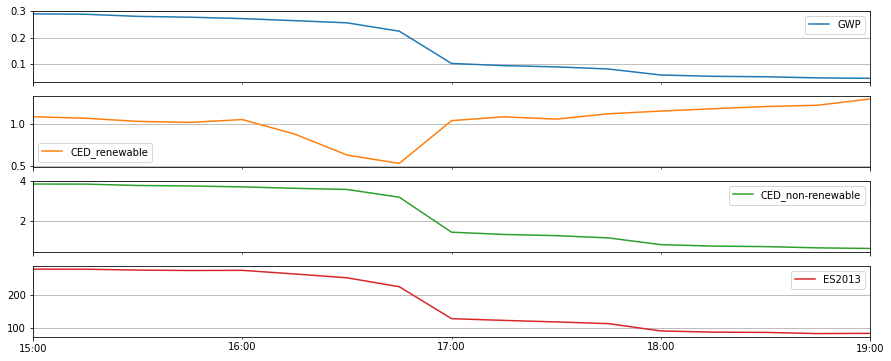

In [66]:
# Represents the impact of 1kWh of electricity consumed in Swizerland
imp['Global'].plot(figsize=(15,6),grid=True, subplots=True)

<AxesSubplot:>

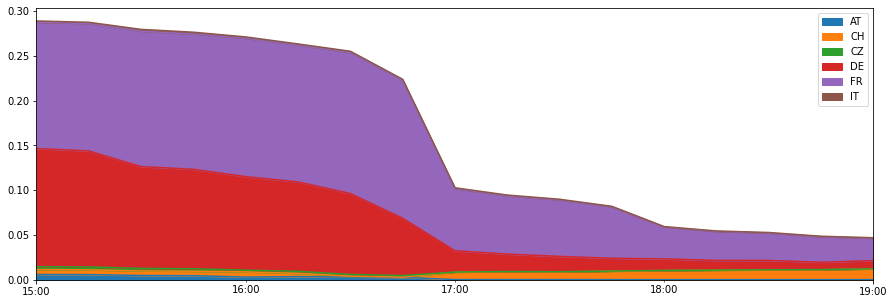

In [67]:
# Represents the detail per country of origin of that kWh of electricity
per_country = compute_per_country(p.ctry,imp['GWP'][[k for k in imp['GWP'].columns if k[:3]!='Mix']])
per_country.plot.area(figsize=(15,5))

<AxesSubplot:>

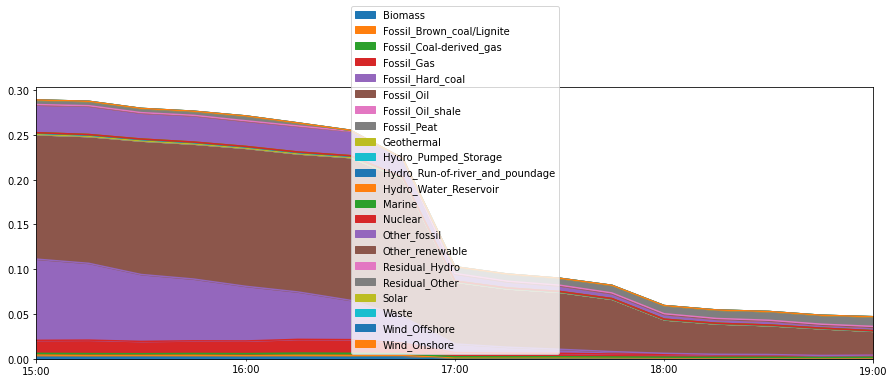

In [68]:
# Represents the detail per country of origin of that kWh of electricity
per_unit = compute_per_unit(imp['GWP'][[k for k in imp['GWP'].columns if k[:3]!='Mix']])
per_unit.plot.area(figsize=(15,5))

<AxesSubplot:title={'center':'GWP impact of the residuals'}, ylabel='GWP impact (kgCO2/kW_el)'>

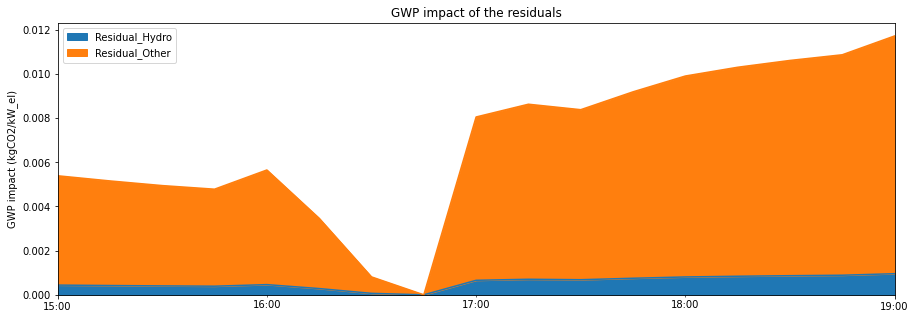

In [69]:
# Represents the detail per country of origin of that kWh of electricity
per_unit = compute_per_unit(imp['GWP'][[k for k in imp['GWP'].columns if k.find('Residual')!=-1]])
per_unit.plot.area(figsize=(15,5),title="GWP impact of the residuals",ylabel="GWP impact (kgCO2/kW_el)")